# **What the Fed Said: Analysis of FOMC Speeches for Application to Financial Markets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# Import libraries

In [ ]:
from __future__ import absolute_import, division, print_function

!pip install pyldavis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import base64
from datetime import datetime

import sys
import re
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

from os.path import isfile, join

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import pipeline
import torch

from sqlalchemy import create_engine, text
from sqlalchemy.pool import NullPool
import sqlalchemy

import json
import glob
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords
spacy.cli.download('en_core_web_sm')
nltk.download('stopwords')
import pyLDAvis
import pyLDAvis.gensim

from nltk.corpus import stopwords as nltk_stopwords
import pyLDAvis.gensim_models

from math import nan

import warnings

import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", category=DeprecationWarning)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


GPU warning. This project can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Import data. Web Scrapping.

* https://www.federalreserve.gov/newsevents/speeches.htm


Pending to improve:


*   Only gets speeches from 2006-2024.
* 2005 or less requires a new function to retrieve the author of the speech
*   Speeches are not 100% clean (special characters, reference  links (bibliography) after speech, html content of videos embedded into the text, etc)
* https://www.federalreserve.gov/newsevents/speech/powell20220524a.htm Example with video embedded in text.
*   A little bit slow (nested for-loop). Around 5mins runtime.






In [ ]:
def get_speech_link(url):
  r = requests.get(url)
  soup = BeautifulSoup(r.text, 'html.parser')
  # Find all <a> tags with href starting with "/newsevents/speech/"
  links = soup.find_all('a', href=lambda href: href and href.startswith('/newsevents/speech/'))
  # Extract href attribute from each link and put them in a list
  speech_links = [link['href'] for link in links]
  return speech_links

def get_speech_text(url):
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  div_content = soup.find('div', class_='col-xs-12 col-sm-8 col-md-8')
  text_content = div_content.text
  return text_content

years_list = [year for year in range(2006, 2025)]
speeches = []
author = []
dates = []
# Define regex pattern to extract name and date from link
pattern = r'/newsevents/speech/(?P<name>[a-zA-Z]+)(?P<year>\d{4})(?P<month>\d{2})(?P<day>\d{2})'

for year in years_list:
  print(year)
  if year < 2011:
    url = f'https://www.federalreserve.gov/newsevents/speech/{str(year)}speech.htm'
  else:
    url = f'https://www.federalreserve.gov/newsevents/speech/{str(year)}-speeches.htm'
  speech_links = get_speech_link(url)  #gets speeches for a certain year

  for link in speech_links:
    text_content = get_speech_text(f'https://www.federalreserve.gov{link}')
    # Match the pattern
    match = re.match(pattern, link)
    # Extract name and date
    if match:
        name = match.group('name')
        year = match.group('year')
        month = match.group('month')
        day = match.group('day')
        # Combine year, month, and day into a date string
        date_str = f"{year}-{month}-{day}"
        # Convert date string to datetime object
        date = datetime.strptime(date_str, '%Y-%m-%d')
        author.append(name)
        dates.append(date)
        speeches.append(text_content)
    else:
        print("No match found.")  #print link that gives error
        print(link)

data = {'Speech': speeches, 'Date':dates, 'Author': author}
df_data = pd.DataFrame(data)
df_data = df_data.sort_values(by='Date')
display(df_data)
# Save DataFrame as CSV
df_data.to_csv('Speeches_Data.csv', index=False)  # Set index=False if you don't want to save the index as a column

2006
2007
No match found.
/newsevents/speech/kroszner2007116a.htm
2008
2009
2010
No match found.
/newsevents/speech/20100407a.htm
2011
2012
2013
No match found.
/newsevents/speech/20130404a.htm
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


,Speech,Date,Author
72,\nI appreciate the opportunity to speak with y...,2006-01-18,bies
71,\nI thank you for the invitation to speak toda...,2006-02-02,bies
70,\nGood morning.\nI would like to begin by than...,2006-02-06,bernanke
69,\nI am honored to deliver the keynote address ...,2006-02-23,ferguson
67,\nIt is a great pleasure for me to return to P...,2006-02-24,bernanke
...,...,...,...
1069,"\nThank you, Matteo. It is my pleasure to welc...",2024-04-16,jefferson
1068,\n\n\n\n\n\n\n\n\n\n\nAccessible Keys for Vide...,2024-04-18,bowman
1067,\nI would like to thank the Massachusetts Bank...,2024-05-03,bowman
1066,\nGovernor Cook delivered identical remarks at...,2024-05-04,cook


In [ ]:
df_data.to_csv('drive/MyDrive/Speeches_Data.csv', index=False)  # Set index=False if you don't want to save the index as a column

# LDA analysis

In [ ]:
def load_data(file):
    # Reading the CSV file into a pandas DataFrame
    data = pd.read_csv(file, encoding="utf-8")
    return data

data = load_data('Speeches_Data.csv')

def filter_speeches_by_date_range(data, start_date, end_date):
    return data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

start_date = '2006-01-01'
end_date = '2024-05-07'

filtered_data = filter_speeches_by_date_range(data, start_date, end_date)
stopwords = nltk_stopwords.words("english")
speech_texts = filtered_data['Speech']


def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

lemmatized_texts = lemmatization(speech_texts)
excluded_terms = ['', '', '']  # Terms to be excluded

def gen_words(texts):
    final = []
    for text in texts:
        new = [word for word in gensim.utils.simple_preprocess(text, deacc=True) if word not in excluded_terms]
        final.append(new)
    return final

data_words = gen_words(lemmatized_texts)

id2word = corpora.Dictionary(data_words)

corpus = [id2word.doc2bow(text) for text in data_words]

lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, random_state=5, update_every=10, chunksize=50, passes=80, alpha='auto')

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
pyLDAvis.display(vis)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


**LDA Topical Distribution**

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-6-4add8e207b1d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['dominant_topic'] = [topic for topic, _ in dominant_topics]
<ipython-input-6-4add8e207b1d>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

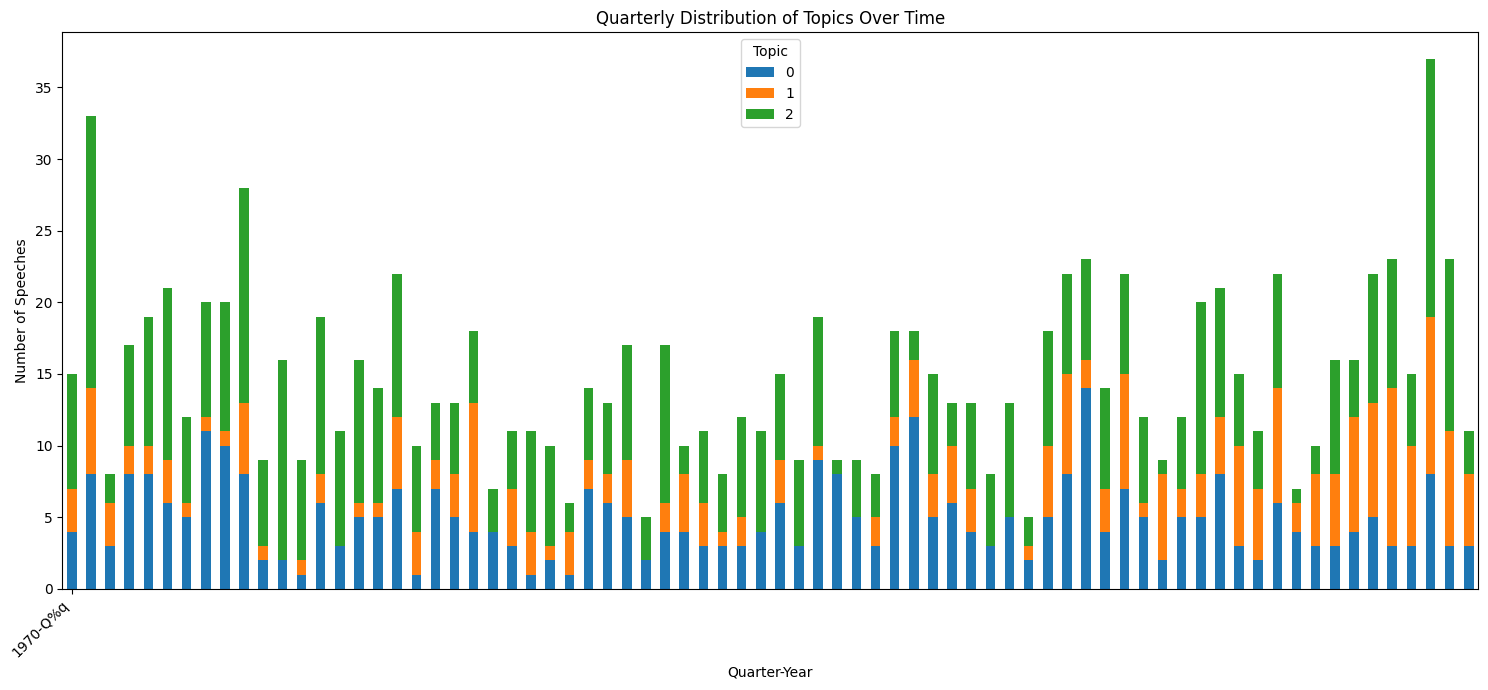

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def load_data(file):
    data = pd.read_csv(file, encoding="utf-8")
    # Ensure the 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    return data

data = load_data('Speeches_Data.csv')

filtered_data = filter_speeches_by_date_range(data, '2006-01-01', '2024-05-07')

lemmatized_texts = lemmatization(filtered_data['Speech'])

data_words = gen_words(lemmatized_texts)
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

lda_model = gensim.models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, random_state=5, update_every=10, chunksize=50, passes=80, alpha='auto')

dominant_topics = []
for _, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:
            dominant_topics.append((topic_num, round(prop_topic,4)))

filtered_data['dominant_topic'] = [topic for topic, _ in dominant_topics]

filtered_data['YearQuarter'] = filtered_data['Date'].dt.to_period('Q')
topic_counts = filtered_data.groupby(['YearQuarter', 'dominant_topic']).agg({'dominant_topic': 'count'})

topic_over_time = topic_counts.unstack(level='dominant_topic').fillna(0)
topic_over_time.columns = topic_over_time.columns.droplevel()

fig, ax = plt.subplots(figsize=(15, 7))
topic_over_time.plot(kind='bar', stacked=True, ax=ax)
plt.xticks(rotation=45, ha="right")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks every quarter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-Q%q'))  # Format as Year-Quarter

plt.title('Quarterly Distribution of Topics Over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()



# Sentiment Analysis

In [ ]:
df1 = pd.read_csv('drive/MyDrive/Speeches_Data.csv')
df1

,Speech,Date,Author
0,\nI appreciate the opportunity to speak with y...,2006-01-18,bies
1,\nI thank you for the invitation to speak toda...,2006-02-02,bies
2,\nGood morning.\nI would like to begin by than...,2006-02-06,bernanke
3,\nI am honored to deliver the keynote address ...,2006-02-23,ferguson
4,\nIt is a great pleasure for me to return to P...,2006-02-24,bernanke
...,...,...,...
1092,"\nThank you, Andrew, and thank you for the opp...",2024-04-03,kugler
1093,"\nThank you, President Musalem, and many congr...",2024-04-04,kugler
1094,\nThank you for the invitation to speak to the...,2024-04-05,bowman
1095,"\nThank you, Matteo. It is my pleasure to welc...",2024-04-16,jefferson


In [ ]:
keep_words = ['inflation expectation', 'interest rate', 'bank rate',

              'fund rate', 'price', 'economic activity', 'inflation', 'employment',

              'unemployment', 'growth', 'exchange rate', 'productivity',

              'deficit', 'demand', 'job market', 'monetary policy',

              'anchor', 'cut', 'subdue', 'decline', 'decrease', 'reduce', 'low',

              'drop', 'fall', 'fell', 'decelerate', 'slow', 'pause', 'pausing',

              'stable', 'non-accelerating', 'downward', 'tighten',

              'ease', 'easing', 'rise', 'rising', 'increase', 'expand',

              'improve', 'strong', 'upward', 'raise', 'high', 'rapid']




In [ ]:
#Try to split speeches into sentence. We will create a new column to store sentence
nltk.download('punkt') # Only needs to be done once

def speech_to_sentence(speech):
  sentences = sent_tokenize(speech)
  return sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### First approach. VADER sentiment analysis.

In [ ]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score for each speech
def get_sentiment_score(text):
    return sid.polarity_scores(text)['compound']

def average_sentiment_score(sentences):
    scores = [get_sentiment_score(sentence) for sentence in sentences]
    if scores:
        return sum(scores) / len(scores)
    else:
        return 0.0  # Return 0 if there are no sentences

def get_sentiment_score_avg(speech):
  sentences = speech_to_sentence(speech)
  filtered_sentences = [sentence for sentence in sentences if any(word in sentence for word in keep_words)]
  average_score = average_sentiment_score(filtered_sentences)
  return average_score


# Apply sentiment analysis to each speech
df1['Vader_sent_score_cutoff'] = df1['Speech'].apply(get_sentiment_score)
df1['Vader_sent_score_avg'] = df1['Speech'].apply(get_sentiment_score_avg)
df1

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Speech,Date,Author,Vader_sent_score_cutoff,Vader_sent_score_avg
0,\nI appreciate the opportunity to speak with y...,2006-01-18,bies,0.9998,0.315328
1,\nI thank you for the invitation to speak toda...,2006-02-02,bies,0.9997,0.255467
2,\nGood morning.\nI would like to begin by than...,2006-02-06,bernanke,0.9986,0.577533
3,\nI am honored to deliver the keynote address ...,2006-02-23,ferguson,0.9999,0.256590
4,\nIt is a great pleasure for me to return to P...,2006-02-24,bernanke,0.9999,0.239007
...,...,...,...,...,...
1092,"\nThank you, Andrew, and thank you for the opp...",2024-04-03,kugler,0.9998,0.201299
1093,"\nThank you, President Musalem, and many congr...",2024-04-04,kugler,0.9998,0.580627
1094,\nThank you for the invitation to speak to the...,2024-04-05,bowman,0.9993,0.081876
1095,"\nThank you, Matteo. It is my pleasure to welc...",2024-04-16,jefferson,0.9946,0.020290


In [ ]:
df1.to_csv('drive/MyDrive/VaderSentiment.csv', index=False)  # Set index=False if you don't want to save the index as a column

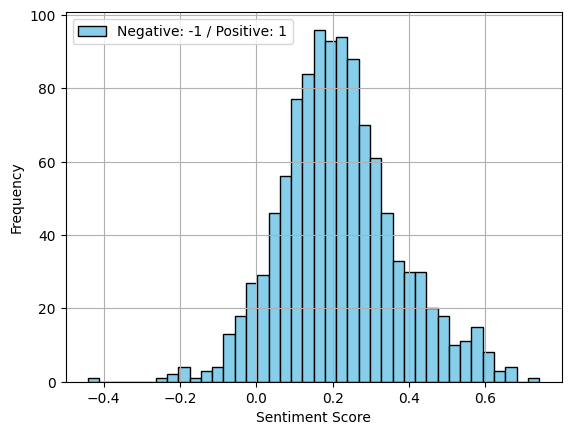

In [ ]:
df1['Vader_sent_score_avg'].plot(kind='hist', bins=40, color='skyblue', edgecolor='black')
#plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Negative: -1 / Positive: 1'], loc='upper left')
plt.show()

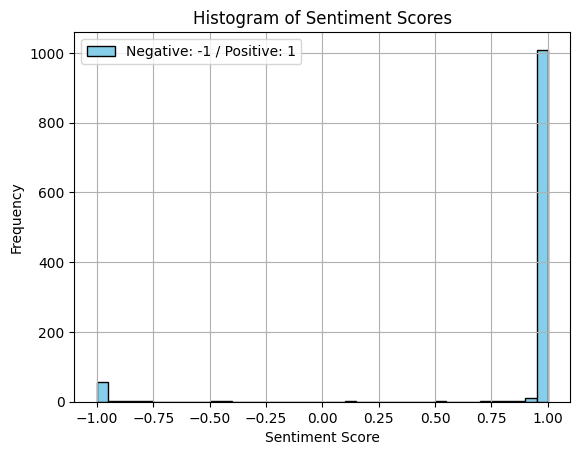

In [ ]:
df1['Vader_sent_score_cutoff'].plot(kind='hist', bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Negative: -1 / Positive: 1'], loc='upper left')
plt.show()


Conclusion: Using Vader and doing a simple full text analysis we observe that pretty much all the speeches are classified as positive

#### Second approach. Using BERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

###### Functions for BERT and FinBERT

In [ ]:
def sentiment_score(speech):
    tokens = tokenizer.encode(speech, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

def l2_avg_sentiment_score(sentences):
    scores = [sentiment_score(sentence) for sentence in sentences]
    if scores:
        return sum(scores) / len(scores), np.linalg.norm(scores)
    else:
        return 0.0  # Return 0 if there are no sentences

def sentiment_score_avg_l2(speech):
  sentences = speech_to_sentence(speech)
  filtered_sentences = [sentence for sentence in sentences if any(word in sentence for word in keep_words)]
  try:
    average_score, l2_norm = l2_avg_sentiment_score(filtered_sentences)
  except:
    average_score, l2_norm = nan, nan
  return pd.Series({'Average Score': average_score,'L2 Norm': l2_norm})

Next cell's runtime is very slow! We apply the sentiment analysis model to all  the relevant sentence in each of the speeches.

In [ ]:
# Apply sentiment analysis to each speech
df1 = pd.read_csv('Speeches_Data.csv')
#test_df = df1.head(5)
new_columns = df1['Speech'].apply(sentiment_score_avg_l2)
df1 = pd.concat([df1, new_columns], axis=1)
df1

In [ ]:
df1.to_csv('drive/MyDrive/BERTSentiment.xlsx', index=False)  # Set index=False if you don't want to save the index as a column

In [ ]:
#Plot results
df1['Average Score'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentiment Scores. BERT.')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Sentiment Score from 1 (negative) to 5 (positive)'], loc='upper left')
plt.show()

For longer texts it is better to split text into several parts and average the sentiment scores.


We get different results with BERT than with VADER, but still the overall tone is positive.

#### Third Approach using FinBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
df1 = pd.read_csv('Speeches_Data.csv')

#test_df = df1.head(5)
new_columns = df1['Speech'].apply(sentiment_score_avg_l2)
df1 = pd.concat([df1, new_columns], axis=1)
df1

In [ ]:
df1.to_csv('drive/MyDrive/finBERTSentiment.xlsx', index=False)  # Set index=False if you don't want to save the index as a column

In [ ]:
df1['Average Score'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentiment Scores. FinBERT.')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Sentiment Score from 1 (negative) to 5 (positive)'], loc='upper left')
plt.show()

In [ ]:
df1['L2 Norm'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of L2 Norm of Sentiment Scores. FinBERT.')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Sentiment Score from 1 (negative) to 5 (positive)'], loc='upper left')
plt.show()

#### Fourth approach. Using RoBERTa fine-tuned.

It runs only the out of sample data (From the last date of the github dataframe) to avoid overfitting

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt")

def classifier_fomc(speech):
  sentences = speech_to_sentence(speech)
  filtered_sentences = [sentence for sentence in sentences if any(word in sentence for word in keep_words)]
  results = classifier(filtered_sentences,
                      batch_size=128, truncation="only_first")

  # Mapping labels to numbers
  label_map = {'LABEL_1': -1, 'LABEL_0': 1, 'LABEL_2':0}   #label 1 means Hawkish, label 0 means dovish, label 2 means neutral
  scores = []
  labels = []
  for entry in results:
      scores.append(entry['score'])
      labels.append(label_map[entry['label']])
  # Convert lists to numpy arrays for element-wise operations
  scores = np.array(scores)
  labels = np.array(labels)
  # Multiplying each score by its corresponding label
  weighted_scores = scores * labels
  # Calculating the average score of labels using numpy's mean function
  average_score_of_labels = np.mean(weighted_scores)

  return average_score_of_labels


In [ ]:
df1 = pd.read_csv('drive/MyDrive/Speeches_Data.csv')    #pd.read_csv('drive/MyDrive/Speeches_Data.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
#recent_df = df1[df1['Date']> '2023-10-14'].copy()
#recent_df['sentiment_RoBERTa'] = recent_df['Speech'].apply(lambda x: classifier_fomc(x))
df1['sentiment_RoBERTa'] = df1['Speech'].apply(lambda x: classifier_fomc(x))

#recent_df

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
df1.to_csv('drive/MyDrive/RoBERTaSentiment.csv', index=False)  # Set index=False if you don't want to save the index as a column

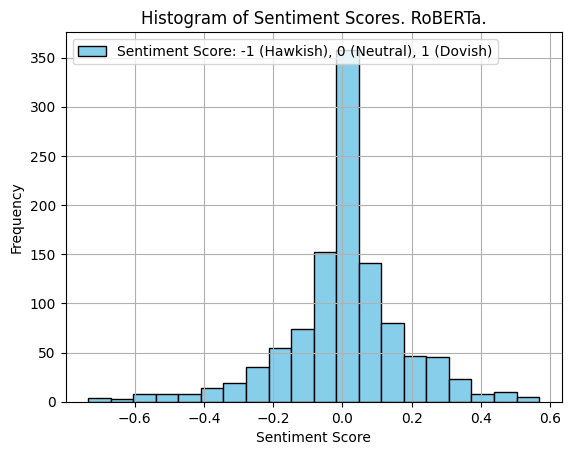

In [ ]:
#recent_df['sentiment_RoBERTa'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
df1['sentiment_RoBERTa'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sentiment Scores. RoBERTa.')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(['Sentiment Score: -1 (Hawkish), 0 (Neutral), 1 (Dovish)'], loc='upper left')
plt.show()

In [ ]:
#How does RoBERTa classifier works?
#Example
results = classifier(["Such a directive would imply that any tightening should be implemented promptly if developments were perceived as pointing to rising inflation.",
                      "The International Monetary Fund projects that global economic growth in 2019 will be the slowest since the financial crisis.", "The crisis is going to be bad"],
                      batch_size=128, truncation="only_first")

print(results)

[{'label': 'LABEL_1', 'score': 0.999393105506897}, {'label': 'LABEL_0', 'score': 0.9979877471923828}, {'label': 'LABEL_2', 'score': 0.5352729558944702}]


# Regressions on Macroeconomic Data using Sentiment



Speeches might shift market expectations and thus conditions

In [ ]:
#Prepare dependent variable
df_1yrTbill = pd.read_csv('drive/MyDrive/DGS1.csv')
df_1yrTbill['Date'] = pd.to_datetime(df_1yrTbill.DATE)
df_1yrTbill['DGS1'] = pd.to_numeric(df_1yrTbill['DGS1'], errors = "coerce")
df_1yrTbill['D_DGS1'] = df_1yrTbill['DGS1'].diff()

df_VIX = pd.read_csv('drive/MyDrive/VIX.csv')
df_VIX['D_VIX'] = (df_VIX['Close'] - df_VIX['Open'])/df_VIX['Open']
df_VIX['VIX'] = df_VIX['Close']
df_VIX['Date'] = pd.to_datetime(df_VIX['Date'])

In [ ]:
#prepare independent variable (BERT)
df_BERT = pd.read_excel('drive/MyDrive/BERTSentiment.xlsx')
df_BERT = df_BERT.rename(columns={'Average Score': 'BERT_avg', 'L2 Norm': 'BERT_L2'})
df_BERT.dropna(inplace = True)
df_BERT = df_BERT.drop_duplicates()

#prepare independent variable (FinBERT)
df_finBERT = pd.read_excel('drive/MyDrive/finBERTSentiment.xlsx')
df_finBERT = df_finBERT.rename(columns={'Average Score': 'finBERT_avg', 'L2 Norm': 'finBERT_L2'})
df_finBERT.dropna(inplace = True)
df_finBERT = df_finBERT.drop_duplicates()

#prepare independent variable (RoBERTa)
df_RoBERTa = pd.read_csv('drive/MyDrive/RoBERTaSentiment.csv')
df_RoBERTa = df_RoBERTa.rename(columns={'sentiment_RoBERTa': 'RoBERTa_avg'})
df_RoBERTa.dropna(inplace = True)
df_RoBERTa = df_RoBERTa.drop_duplicates()
df_RoBERTa['Date'] = pd.to_datetime(df_RoBERTa['Date'])

#prepare independent variable (RoBERTa)
df_VADER = pd.read_csv('drive/MyDrive/VaderSentiment.csv')
df_VADER = df_VADER.rename(columns={'Vader_sent_score_avg': 'VADER_avg'})
df_VADER.dropna(inplace = True)
df_VADER = df_VADER.drop_duplicates()
df_VADER['Date'] = pd.to_datetime(df_VADER['Date'])

In [ ]:
df = df_BERT.merge(df_finBERT, how = 'left', on = ['Date', 'Author'])
df = df.merge(df_RoBERTa, how = 'left', on = ['Date', 'Author'])
df = df.merge(df_VADER, how = 'left', on = ['Date', 'Speech', 'Author'])
df = df.merge(df_1yrTbill, how = 'left', on = 'Date',  validate="m:1")
df = df.merge(df_VIX, how = 'left', on = 'Date',  validate="m:1")
df.Author = df.Author.str.lower()

# Regression of Financial Variables using VADER Average Sentiment Scores

In [ ]:
# OLS Model -- Treasury Yields BIVARIATE
print("\n \n Regression of VADER on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ VADER_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ VADER_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on VADER_avg VIX")
model = smf.ols(formula = 'VIX ~ VADER_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ VADER_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of VADER on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     28.48
Date:                Thu, 09 May 2024   Prob (F-statistic):           1.16e-07
Time:                        02:52:48   Log-Likelihood:                -2186.0
No. Observations:                1058   AIC:                             4376.
Df Residuals:                    1056   BIC:                             4386.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

In [ ]:
# OLS Model -- Treasury Yields EVERYONE
print("\n \n Regression of VADER on level in Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ VADER_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ VADER_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on level VIX")
model = smf.ols(formula = 'VIX ~ VADER_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ VADER_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of VADER on level in Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     37.70
Date:                Thu, 09 May 2024   Prob (F-statistic):          1.06e-126
Time:                        03:54:11   Log-Likelihood:                -1856.8
No. Observations:                1058   AIC:                             3766.
Df Residuals:                    1032   BIC:                             3895.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields EVERYONE
print("\n \n Regression of VADER on level in Treasury Yields")
model = smf.ols(formula = 'BERT_avg ~ DGS1 + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on level VIX")
model = smf.ols(formula = 'BERT_avg ~ VIX + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of VADER on level in Treasury Yields
                            OLS Regression Results                            
Dep. Variable:               BERT_avg   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.896
Date:                Thu, 09 May 2024   Prob (F-statistic):           7.73e-18
Time:                        04:41:40   Log-Likelihood:                -529.87
No. Observations:                1058   AIC:                             1112.
Df Residuals:                    1032   BIC:                             1241.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields CHAIRS AND VICE CHAIRS ONLY
print("\n \n Regression of VADER on level in Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ VADER_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ VADER_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ VADER_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of VADER on level VIX")
model = smf.ols(formula = 'VIX ~ VADER_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())


 
 Regression of VADER on level in Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     20.99
Date:                Thu, 09 May 2024   Prob (F-statistic):           7.83e-31
Time:                        02:53:53   Log-Likelihood:                -1076.1
No. Observations:                 596   AIC:                             2172.
Df Residuals:                     586   BIC:                             2216.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

# Regression of Financial Variables using BERT Average Sentiment Scores

In [ ]:
# OLS Model -- Treasury Yields BIVARIATE
print("\n \n Regression of BERT on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ BERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ BERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on level VIX")
model = smf.ols(formula = 'VIX ~ BERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ BERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of BERT on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     12.51
Date:                Tue, 07 May 2024   Prob (F-statistic):           0.000423
Time:                        23:49:19   Log-Likelihood:                -2193.8
No. Observations:                1058   AIC:                             4392.
Df Residuals:                    1056   BIC:                             4402.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Inte

In [ ]:
# OLS Model -- Treasury Yields EVERYONE
print("\n \n Regression of BERT on level in Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ BERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ BERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on level VIX")
model = smf.ols(formula = 'VIX ~ BERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ BERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of BERT on level in Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     36.46
Date:                Thu, 09 May 2024   Prob (F-statistic):          3.10e-123
Time:                        03:37:11   Log-Likelihood:                -1865.2
No. Observations:                1058   AIC:                             3782.
Df Residuals:                    1032   BIC:                             3911.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields CHAIRS AND VICE CHAIRS ONLY
print("\n \n Regression of BERT on level in Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ BERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ BERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ BERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of BERT on level VIX")
model = smf.ols(formula = 'VIX ~ BERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())


 
 Regression of BERT on level in Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     19.48
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.16e-28
Time:                        23:49:29   Log-Likelihood:                -1081.4
No. Observations:                 596   AIC:                             2183.
Df Residuals:                     586   BIC:                             2227.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# Regression of DGS1 using FinBERT Average Sentiment Scores

In [ ]:
# OLS Model -- Treasury Yields BIVARIATE
print("\n \n Regression of finBERT on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ finBERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ finBERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on level VIX")
model = smf.ols(formula = 'VIX ~ finBERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ finBERT_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of finBERT on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.030
Date:                Tue, 07 May 2024   Prob (F-statistic):              0.310
Time:                        23:49:39   Log-Likelihood:                -2199.5
No. Observations:                1058   AIC:                             4403.
Df Residuals:                    1056   BIC:                             4413.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields EVERYONE
print("\n \n Regression of finBERT on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ finBERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ finBERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on level VIX")
model = smf.ols(formula = 'VIX ~ finBERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ finBERT_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of finBERT on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     36.49
Date:                Thu, 09 May 2024   Prob (F-statistic):          2.59e-123
Time:                        03:38:44   Log-Likelihood:                -1865.0
No. Observations:                1058   AIC:                             3782.
Df Residuals:                    1032   BIC:                             3911.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields CHAIRS AND VICE CHAIRS ONLY
print("\n \n Regression of finBERT on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ finBERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ finBERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on level VIX")
model = smf.ols(formula = 'VIX ~ finBERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of finBERT on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ finBERT_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())


 
 Regression of finBERT on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     19.28
Date:                Tue, 07 May 2024   Prob (F-statistic):           2.23e-28
Time:                        23:50:29   Log-Likelihood:                -1082.1
No. Observations:                 596   AIC:                             2184.
Df Residuals:                     586   BIC:                             2228.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# Regression of DGS1 using RoBERTa Average Sentiment Scores

In [ ]:
# OLS Model -- Treasury Yields BIVARIATE
print("\n \n Regression of RoBERTa on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ RoBERTa_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ RoBERTa_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on level VIX")
model = smf.ols(formula = 'VIX ~ RoBERTa_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ RoBERTa_avg',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of RoBERTa on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     192.5
Date:                Tue, 07 May 2024   Prob (F-statistic):           2.48e-40
Time:                        23:51:39   Log-Likelihood:                -2111.5
No. Observations:                1058   AIC:                             4227.
Df Residuals:                    1056   BIC:                             4237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields EVERYONE
print("\n \n Regression of RoBERTa on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ RoBERTa_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ RoBERTa_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on level VIX")
model = smf.ols(formula = 'VIX ~ RoBERTa_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ RoBERTa_avg + Author',
                data = df,
                missing = 'drop').fit()
print(model.summary())


 
 Regression of RoBERTa on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                     42.90
Date:                Thu, 09 May 2024   Prob (F-statistic):          1.22e-140
Time:                        03:52:12   Log-Likelihood:                -1823.1
No. Observations:                1058   AIC:                             3698.
Df Residuals:                    1032   BIC:                             3827.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
# OLS Model -- Treasury Yields CHAIRS AND VICE CHAIRS ONLY
print("\n \n Regression of RoBERTa on level Treasury Yields")
model = smf.ols(formula = 'DGS1 ~ RoBERTa_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in Treasury Yields")
model = smf.ols(formula = 'D_DGS1 ~ RoBERTa_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on level VIX")
model = smf.ols(formula = 'VIX ~ RoBERTa_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())

print("\n \n Regression of RoBERTa on changes in VIX")
model = smf.ols(formula = 'D_VIX ~ RoBERTa_avg + Author',
                data = df[df.Author.isin(['powell', 'yellen', 'bernanke', 'greenspan', 'jefferson', 'brainard', 'clarida', 'fischer', 'kohn', 'ferguson'])],
                missing = 'drop').fit()
print(model.summary())


 
 Regression of RoBERTa on level Treasury Yields
                            OLS Regression Results                            
Dep. Variable:                   DGS1   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     28.02
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.66e-40
Time:                        23:53:49   Log-Likelihood:                -1052.7
No. Observations:                 596   AIC:                             2125.
Df Residuals:                     586   BIC:                             2169.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

# Application: Trading Strategy

We try to apply the sentiment scores in the market.

In market trading, we have two states：
1. waiting to buy;
2. waiting to sell.

Finbert sentiment
proposal: We will trade based on the average score, but we don't know what parameter we are going to use to trigger the trade. So we are going to learn the parameter by running a simple regression on the returns.

In [ ]:
finBert_sent = pd.read_csv('/content/finBERTSentiment - finBERTSentiment.csv')
finBert_sent['Date'] = pd.to_datetime(finBert_sent.Date,yearfirst=True)
df_SP500 = pd.read_csv('/content/S&P 500.csv')
df_SP500['Date'] = pd.to_datetime(df_SP500.Date,yearfirst=True)
# finBert_sent

# #we only take the most recent data for analyzing
df_finBert_trade = pd.merge(df_SP500,finBert_sent,  how = 'left', on = 'Date')[['Date','Average Score', 'Close/Last']]
df_finBert_trade = df_finBert_trade.sort_values('Date')
df_finBert_trade = df_finBert_trade.dropna()#dropping any NA values
df_finBert_trade = df_finBert_trade.reset_index(drop=True)

df_finBert_trade

,Date,Average Score,Close/Last
0,2019-05-03,2.773333,2945.64
1,2019-05-08,2.594595,2879.42
2,2019-05-09,2.000000,2870.72
3,2019-05-10,2.044944,2881.40
4,2019-05-13,2.571429,2811.87
...,...,...,...
337,2024-04-03,2.606061,5211.49
338,2024-04-04,2.000000,5147.21
339,2024-04-05,2.235294,5204.34
340,2024-04-16,2.532258,5051.41


In [ ]:
def findBert_trading(df,ini_capital,trigger,price):
  n=len(df) #the maximum value for iteration
  df['cash'] = 0
  df['OB'] = 0
  df['shares'] = 0
  #The initial captial is giving by the first row of cash column
  df.loc[0,'cash'] = ini_capital
  #Now we use for loop to update each cells in the three columns
  for i in range(1,n):
      if df.loc[i,'Average Score'] <= trigger:
          if df.loc[i-1,'cash'] != 0: #Buy
              df.loc[i,'cash'] = 0
              df.loc[i,'shares'] = df.loc[i-1,'cash']/df.loc[i,price]
              df.loc[i,'OB'] = df.loc[i-1,'cash']
          else: #Hold
              df.loc[i,'shares'] = df.loc[i-1,'shares']
              df.loc[i,'OB'] = df.loc[i,'shares'] * df.loc[i,price]
      else:
          if df.loc[i-1,'cash'] != 0: #Wait
              df.loc[i,'cash'] = df.loc[i-1,'cash']
          else: #Sell
              df.loc[i,'cash'] = df.loc[i-1,'shares'] * df.loc[i,price]
              df.loc[i,'OB'] = 0
              df.loc[i,'shares'] = 0

  df["Capital"] =    df['cash'] +   df['OB']
  return(df)

In [ ]:
start = df_finBert_trade['Average Score'].min()
end = df_finBert_trade['Average Score'].max()
step_size = 0.1
ini_capital = 100000

p = start # This is the parameter we are going to use as our trigger.

returns_p = {}

#We want to go through possible p values and find out the one that maximize our profit.

while p <= end:
  return_findBert = findBert_trading(df = df_finBert_trade,ini_capital = 100000, trigger = p, price = 'Close/Last')

  returns_p[p] = ((return_findBert["Capital"].iloc[-1]/ini_capital)  - 1)
  p+= step_size



In [ ]:
returns_p

{1.487804878: 0.003862144651035182,
 1.587804878: -0.005741147057816032,
 1.6878048780000001: -0.021454564373394658,
 1.7878048780000002: 0.0679907375237152,
 1.8878048780000003: 0.11505818896332065,
 1.9878048780000004: 0.19702692457675308,
 2.0878048780000005: 0.14876335244231043,
 2.1878048780000006: 0.3751793909108381,
 2.2878048780000007: 0.5604872234931366,
 2.3878048780000007: 0.8419023326169512,
 2.487804878000001: 0.5231841351393622,
 2.587804878000001: 0.6508700618398384,
 2.687804878000001: 0.5315917600163376,
 2.787804878000001: 0.566989540385096,
 2.887804878000001: 0.8190736675371442,
 2.9878048780000013: 0.8190736675371442}

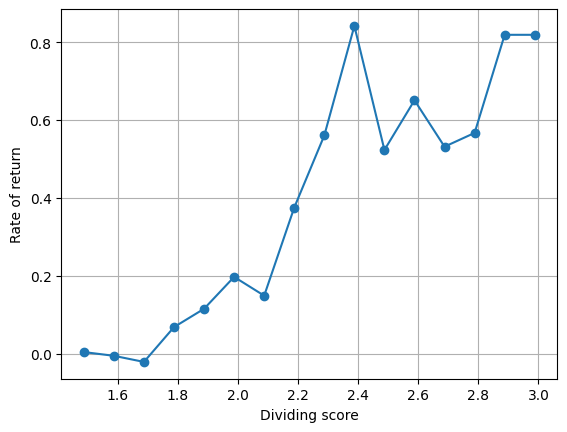

In [ ]:
plt.plot(list(returns_p.keys()), list(returns_p.values()),marker = 'o')
plt.xlabel('Dividing score')
plt.ylabel('Rate of return')
plt.grid(True)
plt.show()

In [ ]:
#We pick the p that gives us the largest return
return_findBert_p = findBert_trading(df = df_finBert_trade,ini_capital = 100000, trigger = 2.38, price = 'Close/Last')

In [ ]:
def get_MA(df,clm_name,MA_n):
    #calculates the n days moving average for the giving column
    # print(3)
    df["Moving Avg " + str(MA_n)] = df[clm_name].rolling(window = MA_n).mean()
    return df

def MA_strategy(df,indicator1,indicator2,price,ini_captial):


      #returns dataframe that shows the capital's change over time.

  df = get_MA(df,price, indicator1)
  df = get_MA(df,price, indicator2)
  df = df.dropna()
  df.reset_index(drop=True,inplace = True) #rest the row index for iteration purpose

  df['cash'] = 0
  df['OB'] = 0
  df['shares'] = 0
  #The initial captial is giving by the first row of cash column
  df.loc[0,'cash'] = ini_captial

  #Now we use for loop to update each cells in the three columns
  for i in range(1,len(df)):
      # print(df)
      if df.loc[i,"Moving Avg " + str(indicator1)] >= df.loc[i,"Moving Avg " + str(indicator2)]:
          # print(2)
          if df.loc[i-1,'cash'] != 0: #Buy
              df.loc[i,'cash'] = 0
              df.loc[i,'shares'] = df.loc[i-1,'cash']/df.loc[i,price]
              df.loc[i,'OB'] = df.loc[i-1,'cash']
          else: #Hold
              df.loc[i,'shares'] = df.loc[i-1,'shares']
              df.loc[i,'OB'] = df.loc[i,'shares'] * df.loc[i,price]
      else:
          if df.loc[i-1,'cash'] != 0: #Wait
              df.loc[i,'cash'] = df.loc[i-1,'cash']
          else: #Sell
              df.loc[i,'cash'] = df.loc[i-1,'shares'] * df.loc[i,price]
              df.loc[i,'OB'] = 0
              df.loc[i,'shares'] = 0

  df["Capital"] =    df['cash'] +   df['OB']
  return df

In [ ]:
df_SP500 = df_SP500.sort_values('Date')
df_SP500 = df_SP500.dropna()#dropping any NA values
df_SP500 = df_SP500.reset_index(drop = True)


df_SP500_trade = MA_strategy(df_SP500,5,10,'Close/Last',100000)
df_SP500_trade

<ipython-input-12-f5d446079e06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cash'] = 0
<ipython-input-12-f5d446079e06>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OB'] = 0
<ipython-input-12-f5d446079e06>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,Date,Close/Last,Open,High,Low,Moving Avg 5,Moving Avg 10,cash,OB,shares,Capital
0,2019-05-03,2945.64,2929.21,2947.85,2929.21,2935.150,2931.070,100000.000000,0.0,0.0,100000.000000
1,2019-05-06,2932.47,2908.89,2937.32,2898.21,2933.038,2933.520,100000.000000,0.0,0.0,100000.000000
2,2019-05-07,2884.05,2913.03,2913.03,2862.60,2920.682,2928.557,100000.000000,0.0,0.0,100000.000000
3,2019-05-08,2879.42,2879.61,2897.96,2873.28,2911.820,2923.774,100000.000000,0.0,0.0,100000.000000
4,2019-05-09,2870.72,2859.84,2875.97,2836.40,2902.460,2918.229,100000.000000,0.0,0.0,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...
1245,2024-04-15,5061.82,5149.67,5168.43,5052.47,5150.968,5172.608,122759.989382,0.0,0.0,122759.989382
1246,2024-04-16,5051.41,5064.59,5079.84,5039.83,5119.268,5157.168,122759.989382,0.0,0.0,122759.989382
1247,2024-04-17,5022.21,5068.97,5077.96,5007.25,5091.582,5138.240,122759.989382,0.0,0.0,122759.989382
1248,2024-04-18,5011.12,5031.52,5056.66,5001.89,5053.994,5124.631,122759.989382,0.0,0.0,122759.989382


In [ ]:
df_finBert_MA = pd.merge(finBert_sent, df_SP500, how = 'left', on = 'Date')[['Date','Average Score','Close/Last']]
df_finBert_MA = df_finBert_MA.sort_values('Date')
df_finBert_MA.reset_index(drop=True,inplace = True) #rest the row index for iteration purpose
df_finBert_MA
df_finBert_MA = df_finBert_MA.dropna()#dropping any NA values

#Converting the required columns to numerical values
# df_finBert_MA['Close/Last'] = pd.to_numeric(df_finBert_MA['Close/Last'], errors='coerce')
print(df_finBert_MA['Close/Last'].dtype)


df_finBert_MA=MA_strategy(df_finBert_MA,5,10,'Close/Last',100000)

<ipython-input-12-f5d446079e06>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cash'] = 0
<ipython-input-12-f5d446079e06>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OB'] = 0
<ipython-input-12-f5d446079e06>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

float64


<ipython-input-12-f5d446079e06>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Capital"] =    df['cash'] +   df['OB']


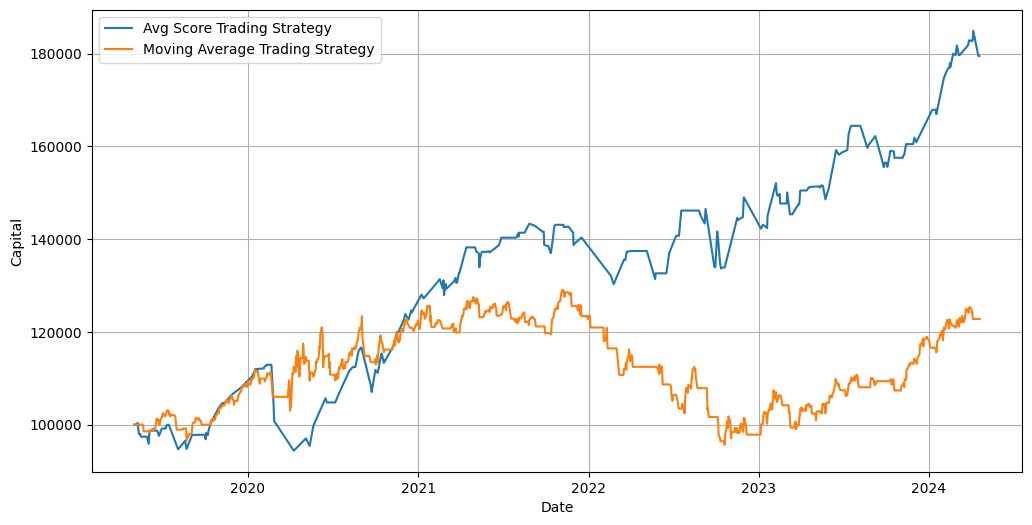

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(return_findBert_p['Date'], return_findBert_p['Capital'], label='Avg Score Trading Strategy')
plt.plot(df_SP500_trade['Date'], df_SP500_trade['Capital'], label='Moving Average Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df3 = df_finBert_trade.copy()
df3.set_index('Date', inplace = True)
df3.loc['2020-01-01':'2020-05-01']

,Average Score,Close/Last,cash,OB,shares,Capital
Date,,,,,,
2020-01-08,2.450000,3253.05,110092.935513,0.000000,0.000000,110092.935513
2020-01-09,2.227273,3274.70,0.000000,110092.935513,33.619243,110092.935513
2020-01-16,1.487805,3316.81,0.000000,111508.641841,33.619243,111508.641841
2020-01-17,2.341463,3329.62,0.000000,111939.304346,33.619243,111939.304346
2020-02-05,2.294118,3334.69,0.000000,112109.753909,33.619243,112109.753909
2020-02-06,2.067568,3345.78,0.000000,112482.591315,33.619243,112482.591315
2020-02-10,1.840000,3352.09,0.000000,112694.728739,33.619243,112694.728739
2020-02-11,2.500000,3357.75,112885.013655,0.000000,0.000000,112885.013655
2020-02-21,2.852941,3337.75,112885.013655,0.000000,0.000000,112885.013655


In [ ]:
df2 = df_SP500_trade.copy()
df2.set_index('Date', inplace=True)
df2.loc['2022-09-01':'2022-01']

,Close/Last,Open,High,Low,Moving Avg 5,Moving Avg 10,cash,OB,shares,Capital
Date,,,,,,,,,,


Now we measure the indicator not by a fixed value but by the score from the previous day

In [ ]:
def findBert_trading_real_time(df,ini_capital,price):
  n=len(df) #the maximum value for iteration
  df['cash'] = 0
  df['OB'] = 0
  df['shares'] = 0
  df["Capital"]=0
  #The initial captial is giving by the first row of cash column
  df.loc[0,'cash'] = ini_capital
  #Now we use for loop to update each cells in the three columns
  for i in range(1,n):
      if df.loc[i,'Average Score'] >= df.loc[i-1,'Average Score']:
          if df.loc[i-1,'cash'] != 0: #Buy
              df.loc[i,'cash'] = 0
              df.loc[i,'shares'] = df.loc[i-1,'cash']/df.loc[i,price]
              df.loc[i,'OB'] = df.loc[i-1,'cash']
          else: #Hold
              df.loc[i,'shares'] = df.loc[i-1,'shares']
              df.loc[i,'OB'] = df.loc[i,'shares'] * df.loc[i,price]
      else:
          if df.loc[i-1,'cash'] != 0: #Wait
              df.loc[i,'cash'] = df.loc[i-1,'cash']
          else: #Sell
              df.loc[i,'cash'] = df.loc[i-1,'shares'] * df.loc[i,price]
              df.loc[i,'OB'] = 0
              df.loc[i,'shares'] = 0

  df["Capital"] =    df['cash'] +   df['OB']
  return(df)

In [ ]:
trad_findBert_last_p = findBert_trading_real_time(df_finBert_trade,100000,"Close/Last")
trad_findBert_last_p

,Date,Average Score,Close/Last,cash,OB,shares,Capital
0,2019-05-03,2.773333,2945.64,100000.000000,0.000000,0.000000,100000.000000
1,2019-05-08,2.594595,2879.42,100000.000000,0.000000,0.000000,100000.000000
2,2019-05-09,2.000000,2870.72,100000.000000,0.000000,0.000000,100000.000000
3,2019-05-10,2.044944,2881.40,0.000000,100000.000000,34.705352,100000.000000
4,2019-05-13,2.571429,2811.87,0.000000,97586.936906,34.705352,97586.936906
...,...,...,...,...,...,...,...
337,2024-04-03,2.606061,5211.49,0.000000,161180.959101,30.927999,161180.959101
338,2024-04-04,2.000000,5147.21,159192.907305,0.000000,0.000000,159192.907305
339,2024-04-05,2.235294,5204.34,0.000000,159192.907305,30.588491,159192.907305
340,2024-04-16,2.532258,5051.41,0.000000,154515.009375,30.588491,154515.009375


We plot it with MA

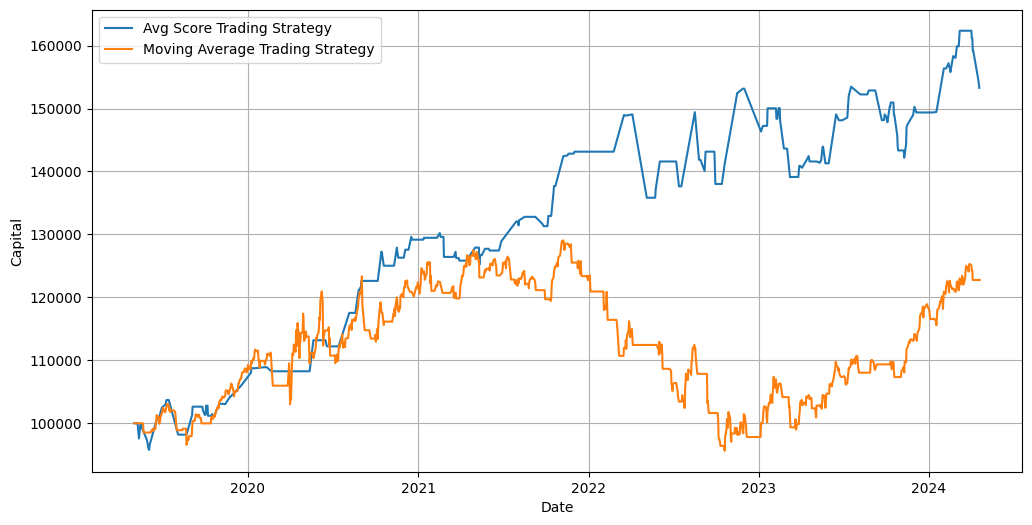

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(trad_findBert_last_p['Date'], trad_findBert_last_p['Capital'], label='Avg Score Trading Strategy')
plt.plot(df_SP500_trade['Date'], df_SP500_trade['Capital'], label='Moving Average Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.grid()
plt.show()

Paragraph FILTERING ON FINBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
def sentiment_score(speech):
    tokens = tokenizer.encode(speech, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

def l2_avg_sentiment_score(sentences):
    scores = [sentiment_score(sentence) for sentence in sentences]
    if scores:
        return sum(scores) / len(scores), np.linalg.norm(scores)
    else:
        return 0.0  # Return 0 if there are no sentences

def sentiment_score_avg_l2(speech):
  sentences = speech_to_sentence(speech)
  filtered_sentences = [sentence for sentence in sentences if any(word in sentence for word in keep_words)]
  try:
    average_score, l2_norm = l2_avg_sentiment_score(filtered_sentences)
  except:
    average_score, l2_norm = nan, nan
  return pd.Series({'Average Score': average_score,'L2 Norm': l2_norm})

In [ ]:
df1 = pd.read_csv('Speeches_Data.csv')

#test_df = df1.head(5)
new_columns = df1['Speech'].apply(sentiment_score_avg_l2)
df1 = pd.concat([df1, new_columns], axis=1)
df1

# REGRESSION USING FINE-TUNED BERT
This is run on the Fed's HPC servers because Collab cannot handle it

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  9 01:30:06 2024

@author: m1cmb07
"""

import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

from transformers import TrainingArguments, Trainer
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from datasets import Dataset
import numpy as np
import math



#set CD
os.chdir('/msu/home/m1cmb07/Personal/MATH5152/project')



#Load in dependent variable
df_1yrTbill = pd.read_csv('DGS1.csv')
df_1yrTbill['Date'] = pd.to_datetime(df_1yrTbill.DATE)
df_1yrTbill['DGS1'] = pd.to_numeric(df_1yrTbill['DGS1'], errors = "coerce")
df_1yrTbill['D_DGS1'] = df_1yrTbill['DGS1'].diff()



#Load in independent variable
df = pd.read_csv('Speeches_Data.csv')
df['Date'] = pd.to_datetime(df.Date)
df_merge = pd.merge(df, df_1yrTbill, how = 'left', on = 'Date')
df_merge.dropna(subset = ['D_DGS1'], inplace = True)



#Split speeches into paragraphs
speeches_tmp = [i.split('\n') for i in df_merge['Speech']]
speeches = [x for xs in speeches_tmp for x in xs]
paragraphs = []
authors = []
dates = []
tbill_changes = []
tbills = []
for x in df_merge['Speech']:
    other_data = df_merge.loc[df_merge['Speech'] == x].reset_index()
    author = other_data['Author'][0]
    date = other_data['DATE'][0]
    tbill_change = other_data['D_DGS1'][0]
    tbill = other_data['DGS1'][0]
    paragraphs_tmp = []
    for xs in x.split('\n'):
        if xs == '':
            pass
        else:
            paragraphs_tmp.append(xs)
    authors.extend([author for x in range(len(paragraphs_tmp))])
    dates.extend([date for x in range(len(paragraphs_tmp))])
    tbill_changes.extend([tbill_change for x in range(len(paragraphs_tmp))])
    tbills.extend([tbill for x in range(len(paragraphs_tmp))])
    paragraphs.extend(paragraphs_tmp)

df_merge = pd.DataFrame([paragraphs, authors, dates, tbill_changes, tbills],
                        ['Speech', 'Author', 'Date', 'D_DGS1', 'DGS1']).T



#Drop paragraphs that do not have
keep_words = ['inflation expectation', 'interest rate', 'bank rate',
              'fund rate', 'price', 'economic activity', 'inflation', 'employment',
              'unemployment', 'growth', 'exchange rate', 'productivity',
              'deficit', 'demand', 'job market', 'monetary policy',
              'anchor', 'cut', 'subdue', 'decline', 'decrease', 'reduce', 'low',
              'drop', 'fall', 'fell', 'decelerate', 'slow', 'pause', 'pausing',
              'stable', 'non-accelerating', 'downward', 'tighten',
              'ease', 'easing', 'rise', 'rising', 'increase', 'expand',
              'improve', 'strong', 'upward', 'raise', 'high', 'rapid']
df_merge = df_merge[df_merge["Speech"].str.contains("|".join(keep_words))]



#Load in model
cache = '/scratch/m1tra00/bert/finbert'
tokenizer = AutoTokenizer.from_pretrained(cache)
model = AutoModelForSequenceClassification.from_pretrained(cache)



#Filter based on sentiment scores
def sentiment_score(speech):
    tokens = tokenizer(speech, padding = True, truncation = True, return_tensors='pt')
    results = model(**tokens)
    predictions = torch.nn.functional.softmax(results.logits, dim = -1)
    positive = predictions[:, 0].tolist()[0]
    negative = predictions[:, 1].tolist()[0]
    neutral = predictions[:, 2].tolist()[0]
    return positive, negative, neutral

df_merge['positive'] = np.nan
df_merge['negative'] = np.nan
df_merge['neutral'] = np.nan
#i = 0
#for speech in list(df_merge['Speech']):
#    df_merge['positive'][i], df_merge['negative'][i], df_merge['neutral'][i] = sentiment_score(speech)
#    i += 1

original_length = len(df_merge['Speech'])

for index, row in df_merge.iterrows():
    df_merge['positive'][index], df_merge['negative'][index], df_merge['neutral'][index] = sentiment_score(row[0])


df_shortened = df_merge[df_merge.neutral < 0.5]
np.shape(df_shortened)[0]
#END HERE





###############################################################################
#####FINE TUNING REGRESSION
###############################################################################
#from https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13, last section

#Hyper params
#LEARNING_RATE = 2e-5 #CONSIDER
MAX_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 20



#Reload model
# Reconfigure model to adjust for regression
config = AutoConfig.from_pretrained(cache, num_labels=1, ignore_mismatched_sizes=True)

# Load the model for sequence classification from the configuration
# This step adjusts the model for regression by setting num_labels to 1
model = AutoModelForSequenceClassification.from_config(config)



#split into train-test-split
train_data_temp, test_data, train_labels_temp, test_labels = train_test_split(df_shortened['Speech'], df_shortened['DGS1'],
                                                                              random_state=2018,
                                                                              test_size=0.3)

train_data, val_data, train_labels, val_labels = train_test_split(train_data_temp, train_labels_temp,
                                                                    random_state=2018,
                                                                    test_size=0.5)

train_df = pd.DataFrame({'text': train_data, 'score': train_labels}).dropna()
val_df = pd.DataFrame({'text': val_data, 'score': val_labels}).dropna()
test_df = pd.DataFrame({'text': test_data, 'score': test_labels}).dropna()

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

ds = {"train": train_ds, "validation": val_ds, "test": test_ds}

print(f'Average length of paragraph is {np.mean([len(i.split()) for i in train_df.text])} words')



#Regression functions
def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])


def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"mse": mse, "mae": mae, "r2": r2}


#Regeression training
training_args = TrainingArguments(
    output_dir="/msu/home/m1cmb07/Personal/MATH5152/project",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="r2",   #changed from accuracy to mse
    greater_is_better = True,    #added for mse because want to minimize #should it be r2 and this greater?
    load_best_model_at_end=True,
    weight_decay=0.01,
)


class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

#evaluation of best accuracy attained by the model
trainer.evaluate()



nb_batches = math.ceil(len(ds["test"])/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["score"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    y_preds += model(**encoded).logits.reshape(-1).tolist()

df = pd.DataFrame([test_ds["text"], test_ds["score"], y_preds], ["Text", "Score", "Prediction"]).T

real_sigma2 = np.var(df['Score'])
reg_mse = np.mean((df['Score'] - df['Prediction'])**2)
red_mse = ((reg_mse - real_sigma2) / real_sigma2) * 100
#df["Rounded Prediction"] = df["Prediction"].apply(round)
#incorrect_cases = df[df["Score"] != df["Rounded Prediction"]]
#test_dstest_ds


#try out on the test data
trainer.eval_dataset=ds["test"]
trainer.evaluate()

## OUTPUT OF BERT FINETUNED REGRESSION

{'eval_loss': 3.7355101108551025,
 'eval_mse': 3.25673521397173962,
 'eval_r2': -12.796956533180321,
 'eval_runtime': 499.9188,
 'eval_samples_per_second': 5.861,
 'eval_steps_per_second': 0.184,
 'epoch': 20.0}

 Model explains 12% of variation in Treasury yields